[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alvarogg777/colabCompression/blob/master/Compress_Lab2.ipynb)

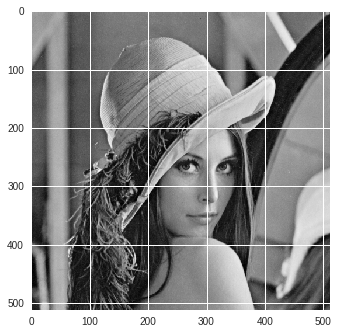

In [1]:
# from operator import add
from matplotlib import pyplot as plt
import numpy as np
import math, PIL, operator
import urllib
from numpy import double

lena_link='https://www.ece.rice.edu/~wakin/images/lena512.bmp'
local_lena,headers=urllib.request.urlretrieve(lena_link,'lena512.bmp')
lena=plt.imread(local_lena)
plt.imshow(lena,cmap='gray')

In [0]:
test=np.array([[88,88,89,90,92,94],[88,88,89,90,92,94]],np.double)

def oneHaar(input_matrix):
  matrix=np.copy(input_matrix,np.double)
  rows,cols=matrix.shape
  evencols=np.arange(cols)[::2]
  lowpass=np.zeros(evencols.shape[0])
  highpass=np.zeros(evencols.shape[0])  
  for row in range(rows):
    for index,i in enumerate(evencols):
      lowpass[index]=(matrix[row,i]+matrix[row,i+1])/2
      highpass[index]=(matrix[row,i]-matrix[row,i+1])/2
    matrix[row,:evencols.shape[0]]=lowpass
    matrix[row,evencols.shape[0]:]=highpass
  return matrix

def revOneHaar(input_matrix):
  matrix=np.copy(input_matrix,np.double)
  rows,cols=matrix.shape
  halfcols=int(cols/2)
  evencols=np.arange(halfcols)
  lowpass=np.zeros(evencols.shape[0])
  highpass=np.zeros(evencols.shape[0])  
  for row in range(rows):
    for index,i in enumerate(evencols):
      lowpass[index]=matrix[row,i]+matrix[row,i+halfcols]
      highpass[index]=matrix[row,i]-matrix[row,i+halfcols]
    matrix[row,]=np.ravel(list(zip(lowpass,highpass)))
  return matrix

In [0]:
def haar_multilevel(input_img, n_transforms):
  haar_img = double(input_img)  
  for i in range(n_transforms):
    arows = np.arange(int(haar_img.shape[0]/2**i))
    acolumns = np.arange(int(haar_img.shape[1]/2**i))
    haar_img[np.ix_(arows,acolumns)] = haar(haar_img[np.ix_(arows,acolumns)])
  return haar_img

def haar(input_img):
  new_img=oneHaar(input_img)
  new_img=oneHaar(np.transpose(new_img))
  return np.transpose(new_img)

def reverse_haar_multilevel(input_img,n_transforms):
  haar_img=double(input_img)
#   print(list(range(n_transforms)[::-1]))
  for i in range(n_transforms)[::-1]:
    rows=np.arange(int(haar_img.shape[0]/(2**i)))
    cols=np.arange(int(haar_img.shape[1]/(2**i)))
    haar_img[np.ix_(rows,cols)]=reverse_haar(haar_img[np.ix_(rows,cols)])
  return haar_img
  
def reverse_haar(input_img):
  new_img=revOneHaar(np.transpose(input_img))
  new_img=revOneHaar(np.transpose(new_img))
  return new_img

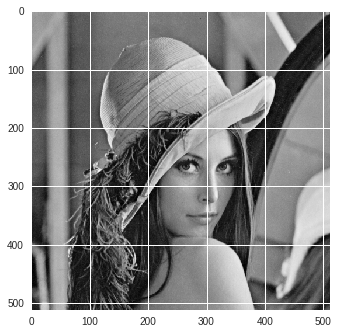

In [4]:
plt.imshow(reverse_haar_multilevel(haar_multilevel(lena,3),3),cmap='gray')

In [0]:
from scipy.ndimage import convolve
def gaussianFilter(input_img,sigma=0.5):
  #Build a 2D Gaussian Filter
  x = np.matrix(np.arange(-5,6)) # sigma = 1, support = ?2:2 (N=5)
#   x = np.arange(-5,6) # sigma = 1, support = ?2:2 (N=5)
  h = np.exp(-(np.power(x,2))/(2*sigma**2)) # Gauss expression 1D
#   h = np.exp(-(x**2)/(2*sigma**2)) # Gauss expression 1D
  h = h/np.sum(h) # Normalize; sum=1
#   G=np.matrix(h).transpose()*np.matrix(h)# 2D mask
  G=h.transpose()*h
#   output_img = imfilter(input_img,G,'same'); # convolve image 
  return convolve(input_img, G)

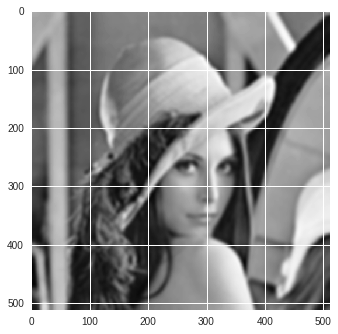

In [6]:
gaussed=gaussianFilter(lena,3)
# print(h.shape)
plt.imshow(gaussed,cmap='gray')

In [0]:
def upsampling(input_img,fact):
  output_img =  np.zeros([int(input_img.shape[0]*fact),input_img.shape[1]])
  j=0
  for k in range(input_img.shape[0]):
      output_img[j,:] = input_img[k,:]
      output_img[j+1,:] = input_img[k,:]
      j=j+2
  return output_img

def downsampling(input_img,fact):
  output_img =  np.zeros([int(input_img.shape[0]/fact),input_img.shape[1]])
  j=0
  for k in range(output_img.shape[0]):
      output_img[k,:] = input_img[j,:]
      j=j+2
  return output_img

In [0]:
def gaussianPyramid(input_img,N):
  decomposition_layers={}
  decomposition_layers[0]=input_img; # first layer is the original image
  for k in range(N):
    gauss_img = gaussianFilter(decomposition_layers[k], 3); 
    aux = downsampling(gauss_img,2);
    decomposition_layers[k+1]= downsampling(aux.T,2).T
  for i in range(len(decomposition_layers)):
    print(decomposition_layers[i].shape)
    plt.figure()
    plt.imshow(decomposition_layers[i],cmap='gray')
  return decomposition_layers

(512, 512)
(256, 256)
(128, 128)
(64, 64)
(32, 32)


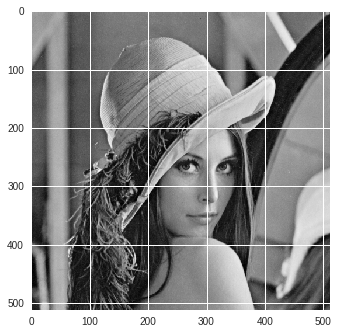

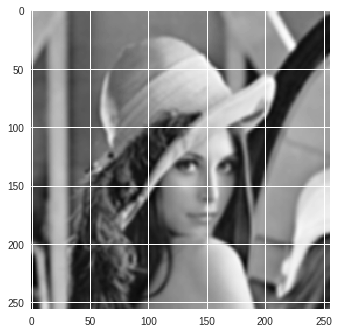

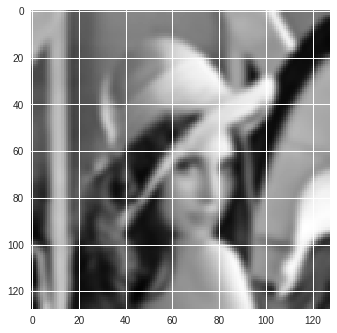

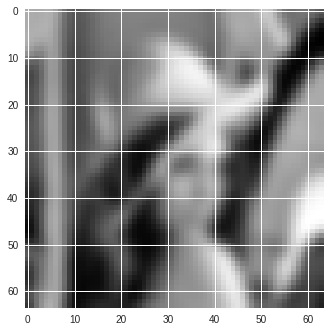

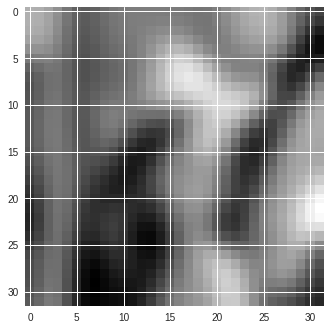

In [9]:
gP=gaussianPyramid(lena,4)

In [0]:
def reverseLaplacian(laplacianPyramid,N):
  j=0
  revIndex=np.arange(0,N+1)[::-1]# to N-1

  rev_decomposition_layers={}
  reversePyramid=laplacianPyramid
  for index,i in enumerate(revIndex[:-1]):
    aux=upsampling(laplacianPyramid[i],2)
    aux=upsampling(aux.T,2).T
    rev_decomposition_layers[j]=aux#+padTop
    j+=1
  for i in rev_decomposition_layers:
    plt.figure()
    plt.imshow(rev_decomposition_layers[i],cmap='gray')
    
  return rev_decomposition_layers

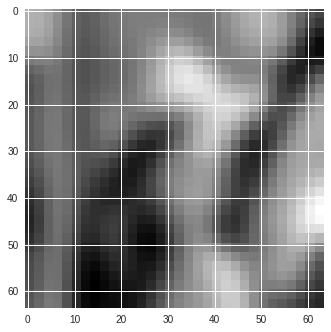

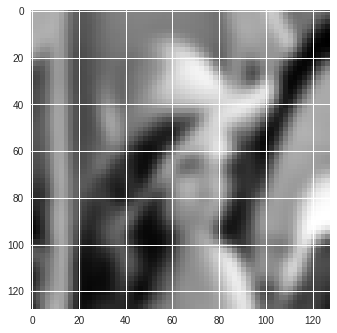

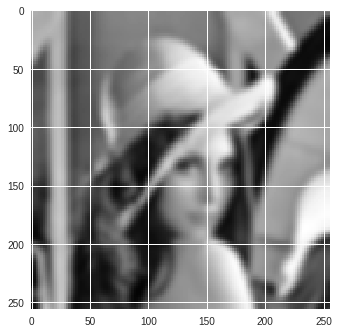

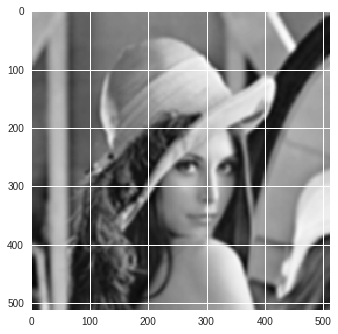

In [11]:
reverseGP=reverseLaplacian(gP,4)